# LOG6302A — Analyse d’applications et Cyber-sécurité<br>Laboratoire #2

**Quentin Guidée (2206809), Nam Vu (2230468)**

Polytechnique Montréal – Hiver 2024


In [132]:
from code_analysis import AST, CFG, ASTReader

In [133]:
import tempfile

from graphviz.sources import Source
from IPython.display import Image


def show_cfg(cfg: CFG) -> Image:
    dot = cfg.to_dot()
    s = Source(dot)
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        s.render(f.name, format="png")
        return Image(f.name + ".png")

In [134]:
class ASTtoCFGVisitor:
    def __init__(self, ast: AST):
        self.ast = ast
        self.cfg = CFG()
        self.curr_nid = 0

    def get_new_nid(self) -> int:
        self.curr_nid += 1
        return self.curr_nid

    @classmethod
    def visit(cls, ast: AST) -> CFG:
        visitor = cls(ast)
        print(f"Visit AST from file {visitor.ast.get_filename()}")
        visitor.visit_root(ast.get_root())
        return visitor.cfg

    def visit_root(self, ast_nid: int) -> int:
        entry_nid = self.get_new_nid()
        self.cfg.set_root(entry_nid)
        self.cfg.set_type(entry_nid, "Entry")
        self.cfg.set_image(entry_nid, "main")
        self.cfg.set_node_ptr(ast_nid, entry_nid)

        exit_nid = self.get_new_nid()
        self.cfg.set_type(exit_nid, "Exit")

        new_parent_cfg_nid = entry_nid
        for child_nid in self.ast.get_children(ast_nid):
            new_parent_cfg_nid = self.visit_node(child_nid, new_parent_cfg_nid)

        self.cfg.add_edge(new_parent_cfg_nid, exit_nid)

        return exit_nid

    def visit_node(self, ast_nid: int, parent_cfg_nid: int) -> int:
        node_type = self.ast.get_type(ast_nid)
        # print(f"Visiting node {ast_nid} ({node_type}) with parent {parent_cfg_nid}")
        # display(show_cfg(self.cfg))
        match node_type:
            case "FunctionCall":
                return self.visit_function_call(ast_nid, parent_cfg_nid)
            case _:
                return self.visit_generic(ast_nid, parent_cfg_nid)

    def visit_function_call(self, ast_nid: int, parent_cfg_nid: int) -> int:
        funccall_nid = self.get_new_nid()
        self.cfg.set_type(funccall_nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(funccall_nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, funccall_nid)

        self.cfg.add_edge(parent_cfg_nid, funccall_nid)

        callbegin_nid = self.get_new_nid()
        self.cfg.set_type(callbegin_nid, "CallBegin")
        self.cfg.set_image(callbegin_nid, self.ast.get_image(ast_nid))

        callend_nid = self.get_new_nid()
        self.cfg.set_type(callend_nid, "CallEnd")
        self.cfg.set_image(callend_nid, self.ast.get_image(ast_nid))

        self.cfg.set_call(callbegin_nid, callend_nid)

        children = self.ast.get_children(ast_nid)
        id_node, arg_nodes = children[0], children[1:]

        id_cfg_nid = self.visit_node(id_node, funccall_nid)
        self.cfg.set_call_expr(callbegin_nid, id_cfg_nid)

        new_parent_cfg_nid = id_cfg_nid
        for child_nid in arg_nodes:
            new_parent_cfg_nid = self.visit_node(child_nid, new_parent_cfg_nid)
            self.cfg.add_call_arg(callbegin_nid, new_parent_cfg_nid)

        self.cfg.add_edge(new_parent_cfg_nid, callbegin_nid)

        retval_nid = self.get_new_nid()
        self.cfg.set_type(retval_nid, "RetValue")

        self.cfg.add_edge(callend_nid, retval_nid)

        return retval_nid

    def visit_generic(self, ast_nid: int, parent_cfg_nid: int) -> int:
        nid = self.get_new_nid()
        self.cfg.set_type(nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, nid)

        self.cfg.add_edge(parent_cfg_nid, nid)

        new_parent_cfg_nid = nid
        for child_nid in self.ast.get_children(ast_nid):
            new_parent_cfg_nid = self.visit_node(child_nid, new_parent_cfg_nid)

        return new_parent_cfg_nid

Visit AST from file code.php


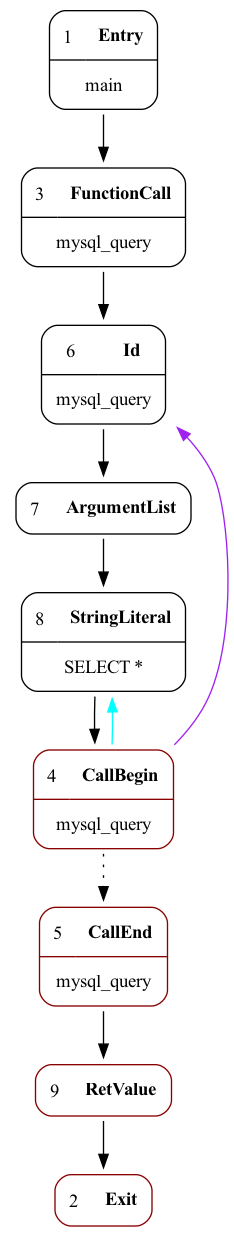

In [135]:
reader = ASTReader()
ast = reader.read_ast("../part_1/functioncall/functioncall.php.ast.json")
cfg = ASTtoCFGVisitor.visit(ast)
show_cfg(cfg)